# A5.2 - Gesture Recognition using SVM
- Jaan Tollander de Balsch - 452056
- 2018-11-19

This report explores gesture recognition from *leap motion* data using *support vector machines* (SVM). The data and the feature designs are both acquired from [1] ([http://lttm.dei.unipd.it/downloads/gesture](http://lttm.dei.unipd.it/downloads/gesture)).

In [21]:
import os
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from numpy.linalg import norm
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler


def parse(filepath) -> Dict[str, List[float]]:
    """Parses a leap motion data from csv file into a dictionary."""
    d = dict()
    with open(filepath, mode='r') as f:
        for line in f:
            v = line.strip('\n').split(',')
            d[v[0]] = list(map(float, v[1:]))
    return d


def angle(v1, v2):
    return np.arccos(np.dot(v1, v2) / (norm(v1) * norm(v2)))


def to_col(v1):
    return v1.reshape((len(v1), 1))


def feature_vector(data):
    # Position of the finger tips
    F = np.array(data["FingertipsPositions"]).reshape((5, 3))

    # Set missing values (vector F[i] is zero vector) to nan.
    for i in range(len(F)):
        if np.all(F[i] == 0):
            F[i, :] = np.nan

    # Palm center
    C = np.array(data["PalmPosition"])

    # Orientation unit vectors
    h = np.array(data["HandDirection"])
    n = np.array(data["PalmNormal"])

    # Index of the middle finger
    middle = 2

    # Scale factor
    S = norm(F[middle]-C)

    # Projection of F to n
    F_pi = to_col(np.dot(F, n.T)) * n

    # Fingertips angle
    A = np.array(list(angle(F_pi_i-C, h) for F_pi_i in F_pi))

    # Fingertips distance
    D = norm(F-C, axis=1) / S

    # Fingertips elevation
    E = np.sign(np.dot((F-F_pi), n)) * norm(F-F_pi, axis=1) / S

    return np.hstack((A, D, E))


def features_and_labels(gesture_path):
    features = []
    labels = []
    label_convert = {"G4": 4, "G5": 5}
    for dirpath, _, filenames in os.walk(gesture_path):
        for filename in filenames:
            _, _, label = dirpath.split('/')
            data = parse(os.path.join(dirpath, filename))
            features.append(feature_vector(data))
            labels.append(label_convert[str(label)])
    return np.array(features), np.array(labels)


def distplot(features, labels):
    feature_names = [f'A_{i}' for i in range(5)] + \
                    [f'D_{i}' for i in range(4)] + \
                    [f'E_{i}' for i in range(5)]
    sns.set()
    for i, name in enumerate(feature_names):
        plt.figure()
        plt.title(f"${name}$")
        sns.distplot([f[i] for (f, l) in zip(features, labels) if l == 4],
                     label="Gesture 4", kde=False, bins=20)
        sns.distplot([f[i] for (f, l) in zip(features, labels) if l == 5],
                     label="Gesture 5", kde=False, bins=20)
        plt.legend()
        plt.show()

## Features and Labels

In [22]:
# Load and create the features and labels from the gesture_set data.
features, labels = features_and_labels("gesture_set")

# Scale the values to range (0.5, 1). This way the are distinquised from 
# the missing values that are set to 0.
scaler = MinMaxScaler((0.5, 1))
scaler.fit(features)
X = scaler.transform(features)
y = labels

# Convert the missing values to 0.
X[np.isnan(X)] = 0

Disribution plots showing the distribution of the values of different features of different gestures.

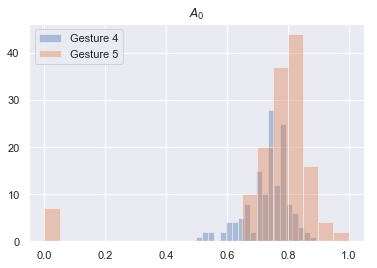

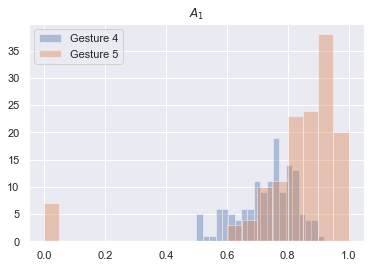

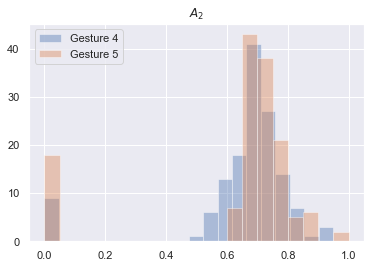

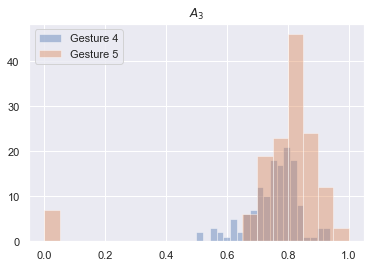

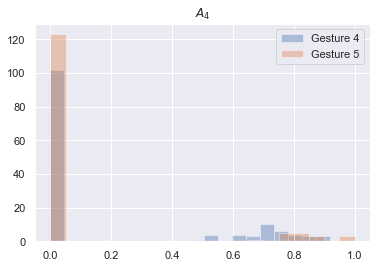

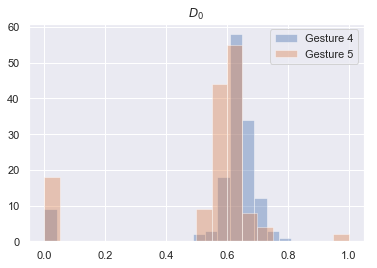

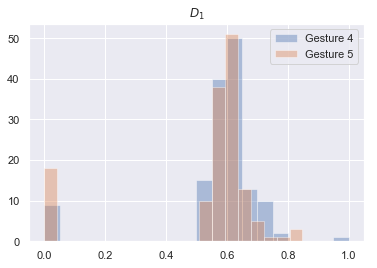

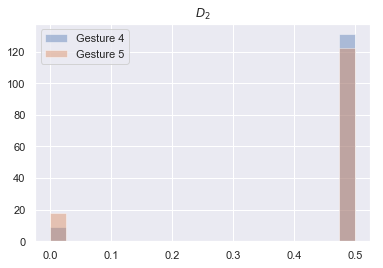

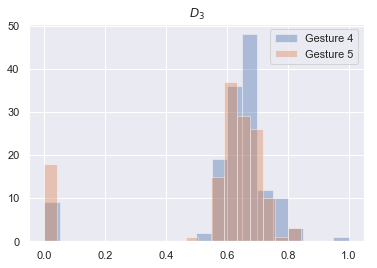

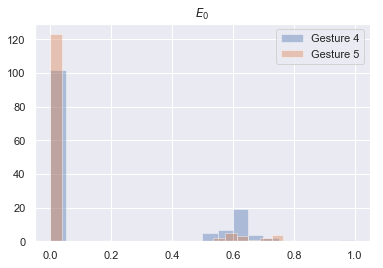

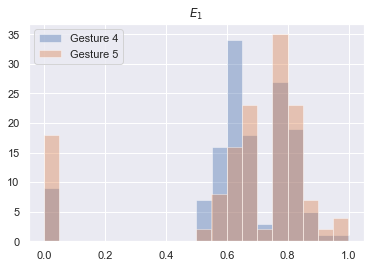

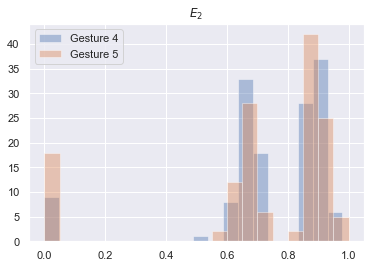

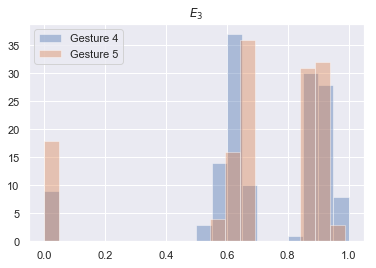

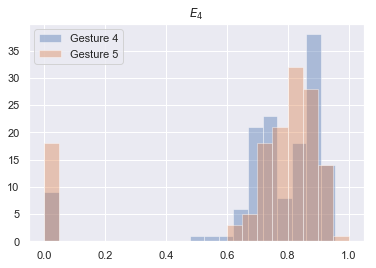

In [19]:
distplot(X, y)

## SVM Model
Support vector machine with linear kernel. The cross validation is done using k-folds with 5 splits.

In [11]:
random_state = 3
clf = svm.SVC(C=2.0, kernel="linear")
cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
clf.fit(X, y)
scores = cross_val_score(clf, X, y, cv=cv)

The cross validation accuracy metrics.

In [13]:
print(f"Accuracy: {scores.mean():.2f} (+/- {2*scores.std():0.2f})")

Accuracy: 0.75 (+/- 0.14)


The predicted values.

In [14]:
y_pred = clf.predict(X)

The classification report

In [15]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           4       0.78      0.75      0.77       140
           5       0.76      0.79      0.78       140

   micro avg       0.77      0.77      0.77       280
   macro avg       0.77      0.77      0.77       280
weighted avg       0.77      0.77      0.77       280



The confuction matrix

In [16]:
print(confusion_matrix(y, y_pred))

[[105  35]
 [ 29 111]]


## References
[1] Marin, G., Dominio, F., & Zanuttigh, P. (2014). Hand Gesture Recognition with Leap Motion and Kinect Devices. International Conference on Image Processing(ICIP), 1565–1569. https://doi.org/10.1109/ICIP.2014.7025313